


# Does PySINDy performance vary with the level of chaos, the level of syntactic complexity, or how multi-scale the system is?

This notebook investigates a large database of chaotic systems of pure polynomial expression and polynomial degree <= 4, in order to see if the performance of PySINDy varies with the level of chaos (as measured by the largest Lyapunov exponent) or the level of syntactic complexity.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
from dysts.base import make_trajectory_ensemble
from dysts.base import get_attractor_list
import dysts.flows as flows
import dysts.datasets as datasets
import time

from utils import *

# Annoyingly requires the neurokit2 package - "pip install neurokit2"
from dysts.analysis import sample_initial_conditions

import pysindy as ps

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Seed the random number generators for reproducibility
np.random.seed(100)

# Chaotic System Initialization

This experiment include 77 chaotic systems provided by the database from William Gilpin. "Chaos as an interpretable benchmark for forecasting and data-driven modelling" Advances in Neural Information Processing Systems (NeurIPS) 2021 https://arxiv.org/abs/2110.05266.

In [2]:
t1 = time.time()

# experimental system list
systems_list = ["AtmosphericRegime"]
# ["Aizawa", "Arneodo", "Bouali2", 
#                 "GenesioTesi", "HyperBao", "HyperCai", "HyperJha", 
#                 "HyperLorenz", "HyperLu", "HyperPang", "Laser",
#                 "Lorenz", 
#                 "LorenzBounded", 
#                 "MooreSpiegel", "Rossler", "ShimizuMorioka",
#                 # Added a bunch of additional polynomial systems
#                 "HenonHeiles", "GuckenheimerHolmes", "Halvorsen", "KawczynskiStrizhak",
#                 "VallisElNino", "RabinovichFabrikant", "NoseHoover", "Dadras", "RikitakeDynamo",
#                 "NuclearQuadrupole", "PehlivanWei", "SprottTorus", "SprottJerk", "SprottA", "SprottB",
#                 "SprottC", "SprottD", "SprottE", "SprottF", "SprottG", "SprottH", "SprottI", "SprottJ",
#                 "SprottK", "SprottL", "SprottM", "SprottN", "SprottO", "SprottP", "SprottQ", "SprottR",
#                 "SprottS", "Rucklidge", "Sakarya", "RayleighBenard", "Finance", "LuChenCheng",
#                 "LuChen", "QiChen", "ZhouChen", "BurkeShaw", "Chen", "ChenLee", "WangSun", "DequanLi",
#                 "NewtonLiepnik", "HyperRossler", "HyperQi", "Qi", "LorenzStenflo", "HyperYangChen", 
#                 "HyperYan", "HyperXu", "HyperWang", "AtmosphericRegime", "Hadley", "HindmarshRose",
#                ]
alphabetical_sort = np.argsort(systems_list)
systems_list = np.array(systems_list)[alphabetical_sort]


# attributes list
attributes = [
    "maximum_lyapunov_estimated",
    "embedding_dimension",
    "parameters"
]

# Get training and testing trajectories for all the experimental systems and their attributes
n = 50000
all_sols_train = dict()
all_sols_test = dict()
all_t_train = dict()
all_t_test = dict()
all_properties = dict()

for i, equation_name in enumerate(systems_list):
    eq = getattr(flows, equation_name)()
    print(i, eq)
    try:
        ic_train, ic_test = sample_initial_conditions(eq, 2, traj_length=1000, pts_per_period=30)
        eq.ic = ic_train
        t_sol, sol = eq.make_trajectory(n, method="Radau", resample=False, return_times=True, standardize=False)
        all_sols_train[equation_name] = sol
        all_t_train[equation_name] = t_sol
        eq.ic = ic_test
        t_sol, sol = eq.make_trajectory(n, method="Radau", resample=False, return_times=True, standardize=False)
        all_sols_test[equation_name] = sol
        all_t_test[equation_name] = t_sol
        attr_vals = [getattr(eq, item, None) for item in attributes]
        all_properties[equation_name] = dict(zip(attributes, attr_vals))
    except SystemError:
        print('Could not load one of the systems: ', equation_name)
    except TypeError:
        print('Could not load one of the systems ', equation_name)
        
t2 = time.time()
print('Took ', t2 - t1, ' seconds to load the systems')

0 AtmosphericRegime(name='AtmosphericRegime', params={'alpha': -2.0, 'beta': -5.0, 'mu1': 0.05, 'mu2': -0.01, 'omega': 3.0, 'sigma': 1.1}, random_state=None)
Took  13.018996953964233  seconds to load the systems


In [3]:
num_attractors = len(systems_list)

lyap_list = []
dimension_list = []
param_list = []

for system in systems_list:
    lyap_list.append(all_properties[system]['maximum_lyapunov_estimated'])
    dimension_list.append(all_properties[system]['embedding_dimension'])
    param_list.append(all_properties[system]['parameters'])


# Make list of the number of polynomial terms in each system1
nonlin_list = [4, 3, 3, 
               2, 2, 2, 2, 
               2, 2, 2, 3, 
               2, 2, 3, 2, 2,
               2, 3, 2, 3, 
               2, 3, 2, 2, 2,
               3, 2, 2, 2, 2, 2,
               2, 2, 2, 2, 2, 2, 2, 2,
               2, 2, 2, 2, 2, 2, 2, 2,
               2, 2, 2, 2, 2, 2,
               2, 2, 2, 2, 2, 2, 2, 2, 
               2, 2, 2, 3, 2, 2, 
               2, 2, 2, 2, 2, 3, 
              ]
# number_nonlinear_terms = get_nonlinear_terms(num_attractors)
# number_nonlinear_terms = number_nonlinear_terms[alphabetical_sort, :]
true_coefficients = make_dysts_true_coefficients(systems_list, all_sols_train, dimension_list, param_list)

## Trajectory Visualization

Took  0.45666003227233887  seconds to plot the systems


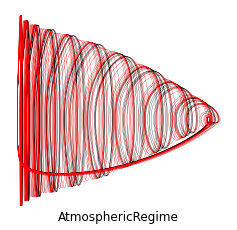

In [4]:
t1 = time.time()

# Plot the training and testing trajectories for all the chaotic systems
num_rows = 5
num_cols = int(np.ceil(len(all_sols_train) / num_rows))
fig = plt.figure(figsize=(num_cols * 4, num_rows * 4))

gs = plt.matplotlib.gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.0, hspace=0.05) 

for i, attractor_name in enumerate(all_sols_train):
    
    x_train = all_sols_train[attractor_name]
    x_test = all_sols_test[attractor_name]
    t_train = all_t_train[attractor_name]
    t_test = all_t_test[attractor_name]
    
    plt.subplot(gs[i])
    plt.plot(x_train[:, 0], x_train[:, 1], 'k', linewidth=0.25)
    plt.plot(x_test[:, 0], x_test[:, 1], 'r', linewidth=0.25)
    plt.title(attractor_name, y=-0.05)
    plt.gca().axis('off')
            
plt.savefig('polynomial_attractors.jpg')
plt.savefig('polynomial_attractors.pdf')
t2 = time.time()
print('Took ', t2 - t1, ' seconds to plot the systems')

# Define some metrics for performance

The normalized root-mean-square-error, the normalized coefficient errors, the success rate, and other metrics

In [5]:
def normalized_RMSE(x_dot_true, x_dot_pred):
    """
    """
    return np.linalg.norm(x_dot_true - x_dot_pred) / np.linalg.norm(x_dot_true)

def total_coefficient_error(xi_true, xi_pred):
    return np.linalg.norm(xi_true - xi_pred) / np.linalg.norm(xi_true)

def coefficient_errors(xi_true, xi_pred):
    errors = np.zeros(xi_true.shape)
    for i in range(xi_true.shape[0]):
        for j in range(xi_true.shape[1]):
            if np.isclose(xi_true[i, j], 0.0):
                errors[i, j] = abs(xi_true[i, j] - xi_pred[i, j])
            else:
                errors[i, j] = abs(xi_true[i, j] - xi_pred[i, j]) / xi_true[i, j]
    return errors

def success_rate(xi_true, xi_pred):
    print('to do')
    
#def stability_metric():

## Compute RMSEs and Normalized Errors

0  /  1 , System =  AtmosphericRegime
[[ 0.00000000e+00  5.00049143e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.09942497e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  2.97350014e-03  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.08820963e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -9.99923844e-03  2.99859593e+00
  -1.09943470e+00  0.00000000e+00  0.00000000e+00 -7.18302263e-03
  -1.99325605e+00 -4.99045046e+00  0.00000000e+00 -2.06156029e-03
  -3.09430465e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   9.74975504e-03  2.07695141e-02 -2.94330885e-02 -1.92556549e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.

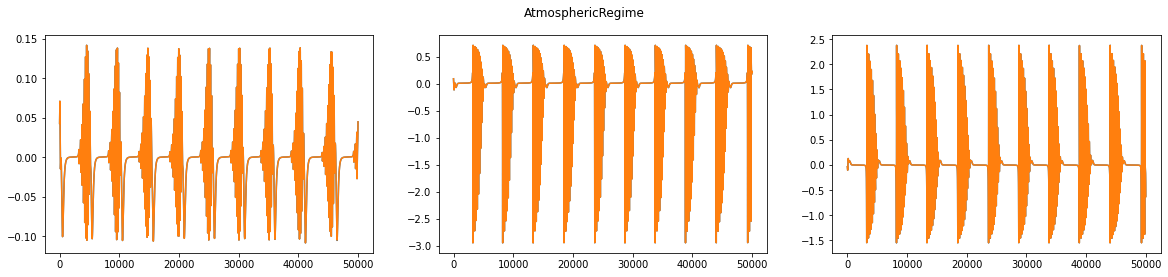

In [6]:
t1 = time.time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

# define data structure for records
xdot_rmse_errors = {}
xdot_coef_errors = {}
predicted_coefficients = {}

# initialize sturctures
for system in systems_list:
    xdot_rmse_errors[system] = list()
    xdot_coef_errors[system] = list()
    predicted_coefficients[system] = list()
    
# iterate over all systems and noise levels
num_fits = 1
max_iter = 50
tol_iter = 40
num_error_levels = 1
error_levels = np.linspace(0.01, 0.2, num_error_levels)
poly_library = ps.PolynomialLibrary(degree=4)
models = []

for i, attractor_name in enumerate(systems_list):
    print(i, " / ", num_attractors, ", System = ", attractor_name)

    x_train = all_sols_train[attractor_name]
    x_test = all_sols_test[attractor_name]
    t_train = all_t_train[attractor_name]
    t_test = all_t_test[attractor_name]
    
    # noise variance controller
    rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
    
    for error in error_levels:
        # multiple test for averaged results
        errors_temp = []
        coef_errors_temp = []
        pred_coefs_temp = []
        for j in range(num_fits):
            # contruct noisy data
            x_train_noisy = x_train  #+ np.random.normal(0, rmse * error, x_train.shape)
            
            # rudy train
            coef_best, err_best, coef_history, err_history, model = rudy_algorithm2(
                x_train_noisy, x_test, t_train,
                ode_lib=poly_library, dtol=1e-3,
                optimizer_max_iter=max_iter,
                tol_iter=tol_iter,
                change_factor=1.2,
                l0_pen=1e-1,
                alpha=0.0,
                normalize_columns=False,
                t_test=t_test
            )
            #print(coef_best)

            x_dot_test = model.differentiate(x_test, t=t_test)
            x_dot_test_pred = model.predict(x_test)
            plt.figure(1 + i, figsize=(20, 4))
            plt.suptitle(attractor_name)
            plt.subplot(1, 3, 1)
            plt.plot(x_dot_test[:, 0])
            plt.plot(x_dot_test_pred[:, 0])
            plt.subplot(1, 3, 2)
            plt.plot(x_dot_test[:, 1])
            plt.plot(x_dot_test_pred[:, 1])
            plt.subplot(1, 3, 3)
            plt.plot(x_dot_test[:, 2])
            plt.plot(x_dot_test_pred[:, 2])
#             x_test_pred = model.simulate(x_test[0, :], t=t_test, integrator="odeint",
#                                          integrator_kws={"mxstep":30})
            errors_temp.append(normalized_RMSE(x_dot_test, x_dot_test_pred))
            coef_errors_temp.append(coefficient_errors(true_coefficients[i], coef_best))
            pred_coefs_temp.append(coef_best)
            models.append(model)
                
        # compute and record normalized errors
        #print(np.array(coef_errors_temp).shape)
        xdot_rmse_errors[attractor_name].append(np.mean(np.array(errors_temp), axis=0))
        xdot_coef_errors[attractor_name].append(np.mean(np.array(coef_errors_temp), axis=0))
        predicted_coefficients[attractor_name].append(np.mean(np.array(pred_coefs_temp), axis=0))
            
t2 = time.time()
print('Total time to compute (num_fits x num_error_levels x num_attractors = ', 
      num_fits, ' x ', num_error_levels, ' x ', num_attractors, ' = ',
      num_fits * num_error_levels * num_attractors, ') = ', t2 - t1, ' seconds')


### Normalized Error

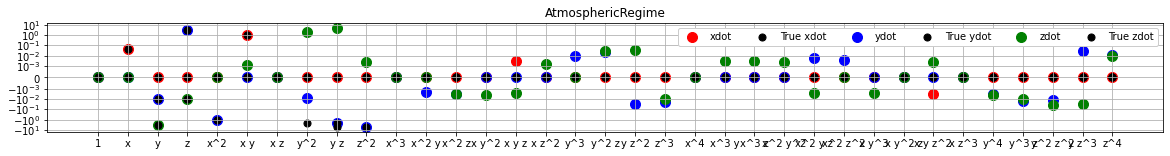

In [7]:
colors = ['r', 'b', 'g', 'm']
labels = ['xdot', 'ydot', 'zdot', 'wdot']

for i, system in enumerate(systems_list):
    x_train = all_sols_train[system]
    plt.figure(figsize=(20, 2))
    if dimension_list[i] == 3:
        feature_names = poly_library.fit(x_train).get_feature_names(['x', 'y', 'z'])
    else:
        feature_names = poly_library.fit(x_train).get_feature_names(['x', 'y', 'z', 'w'])
    for k in range(dimension_list[i]):
        #print(i, k, system, dimension_list[i])
        plt.grid(True)
        plt.scatter(feature_names, np.array(predicted_coefficients[system])[0, k, :], 
                        color=colors[k], label=labels[k], s=100)
        plt.scatter(feature_names, np.array(true_coefficients[i][k, :]), 
                        color='k', label='True ' + labels[k], s=50)
    if dimension_list[i] == 3:
        plt.legend(loc='upper right', framealpha=1.0, ncol=6)
    else:
        plt.legend(loc='upper right', framealpha=1.0, ncol=8)
    plt.title(system)
    plt.yscale('symlog', linthreshy=1e-3)
    plt.legend(loc='upper right', framealpha=1.0, ncol=6)


In [8]:
print(model.optimizer.coef_, coef_best, model.optimizer.history_[-1])

[[ 0.00000000e+00  5.00049143e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.09942497e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  2.97350014e-03  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.08820963e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -9.99923844e-03  2.99859593e+00
  -1.09943470e+00  0.00000000e+00  0.00000000e+00 -7.18302263e-03
  -1.99325605e+00 -4.99045046e+00  0.00000000e+00 -2.06156029e-03
  -3.09430465e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   9.74975504e-03  2.07695141e-02 -2.94330885e-02 -1.92556549e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   5.51559318e-03  3.6046

0 SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=4),
      feature_names=['x0', 'x1', 'x2'],
      optimizer=STLSQ(alpha=0.0, max_iter=50, ridge_kw={'tol': 1e-10},
                      threshold=0.001)) AtmosphericRegime (50000,) (50000, 3) (50000, 3)
0.008860427972344702


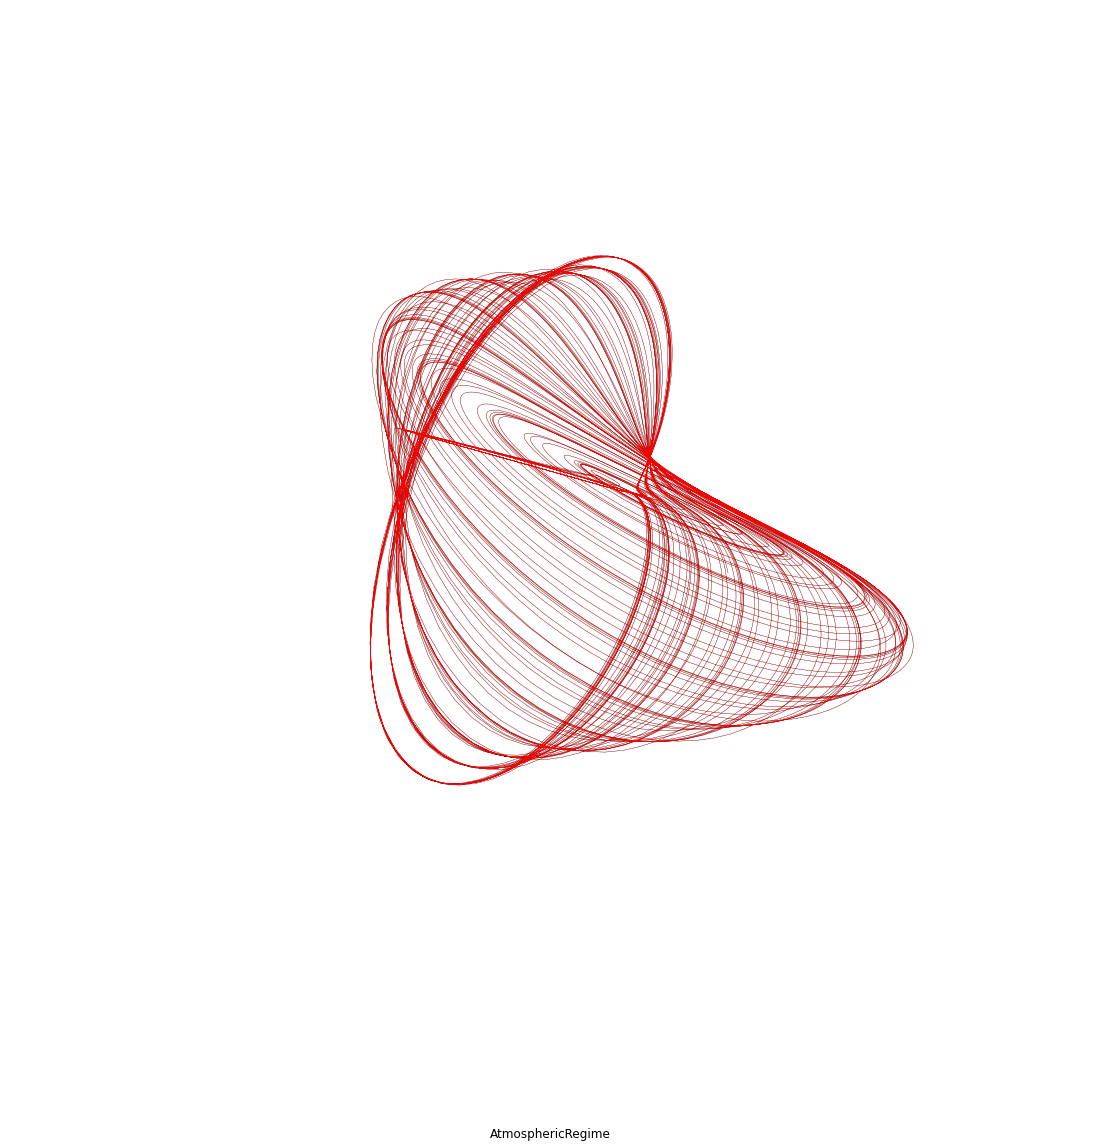

In [9]:
# Plot the training and testing trajectories for all the chaotic systems
num_rows = int(np.ceil(len(all_sols_train) / num_rows))
num_cols = 5
#fig = plt.figure(figsize=(num_cols * 4, num_rows * 4))
fig = plt.figure(figsize=(20, 20))

gs = plt.matplotlib.gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.0, hspace=0.05) 

for i, attractor_name in enumerate(all_sols_train):
    
    x_test = all_sols_test[attractor_name]
    t_test = all_t_test[attractor_name]
    print(i, models[i], attractor_name, t_test.shape, x_test.shape, all_sols_train[attractor_name].shape)

    x_dot_test = models[i].differentiate(x_test, t=t_test)
    x_dot_test_pred = models[i].predict(x_test)
    
    ax = fig.add_subplot(projection='3d')

    plt.plot(x_dot_test[:, 0], x_dot_test[:, 1], x_dot_test[:, 2], 'k', linewidth=0.25)
    plt.plot(x_dot_test_pred[:, 0], x_dot_test_pred[:, 1], x_dot_test[:, 2], 'r', linewidth=0.25)
    plt.title(attractor_name, y=-0.05)
    print(np.linalg.norm(x_dot_test - x_dot_test_pred, 2) ** 2)
    plt.gca().axis('off')
            
plt.savefig('polynomial_attractors_fits.jpg')
plt.savefig('polynomial_attractors_fits.pdf')